In [1]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb 

/home/tianshengs/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def TimeSeriesGridSearchCV(f, grid, fit_params=None, n_splits=5, verbose=0):
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv     = TimeSeriesSplit(n_splits)
    return GridSearchCV(f, grid, scoring=scorer, fit_params=fit_params, iid=False, refit=True,cv=cv, verbose=verbose)

In [3]:
def split_sj_and_iq_feature(input_feature):
    data =pd.read_csv(input_feature, index_col = [0,1,3])
    sj = data.loc["sj"]
    iq = data.loc["iq"]
    return sj, iq

def split_sj_and_iq_label(input_feature):
    data =pd.read_csv(input_feature, index_col = [0,1,2])
    sj = data.loc["sj"]
    iq = data.loc["iq"]
    return sj, iq

In [4]:
sj_train_features, iq_train_features = split_sj_and_iq_feature("Downloads/dengue_features_train.csv")
sj_train_labels, iq_train_labels = split_sj_and_iq_label("Downloads/dengue_labels_train.csv")
sj_test_features,iq_test_features = split_sj_and_iq_feature("Downloads/dengue_features_test.csv")
sj_submission, iq_submission = split_sj_and_iq_label("Downloads/submission_format.csv")

In [5]:
sj_y = sj_train_labels.as_matrix()
iq_y = iq_train_labels.as_matrix()

In [6]:
sj_train_features.fillna(method='bfill', inplace=True)
iq_train_features.fillna(method='bfill', inplace=True)
sj_test_features.fillna(method='bfill', inplace=True)
iq_test_features.fillna(method='bfill', inplace=True) 

In [7]:
def add_features(data):
    data['cosweekofyear'] = np.cos((data['weekofyear']/52)*2*np.pi)
    data['ndvi'] = (data['ndvi_ne'] + data['ndvi_nw'] + data['ndvi_se'] + data["ndvi_sw"])
    data['precipitation'] = (data['station_precip_mm'] + data['precipitation_amt_mm'])/2
    return data

In [8]:
sj_train_features = add_features(sj_train_features)
iq_train_features = add_features(iq_train_features)
sj_test_features = add_features(sj_test_features)
iq_test_features = add_features(iq_test_features)

In [9]:
features = ["precipitation", 'station_max_temp_c', 'reanalysis_relative_humidity_percent',
                 'station_avg_temp_c', 
                 'station_min_temp_c', 'ndvi','cosweekofyear']

In [10]:
def select_features(data, features):   
    data = data[features]    
    return data

In [11]:
sj_train = select_features(sj_train_features, features)
iq_train = select_features(iq_train_features, features)
sj_test = select_features(sj_test_features, features)
iq_test = select_features(iq_test_features, features)

In [12]:
sj_train

precipitation  station_max_temp_c  \
year week_start_date                                      
1990 1990-04-30              14.210                29.4   
     1990-05-07              15.710                31.7   
     1990-05-14              37.970                32.2   
     1990-05-21               9.680                33.3   
     1990-05-28               6.660                35.0   
     1990-06-04              24.340                34.4   
     1990-06-11              16.590                32.2   
     1990-06-18              86.110                33.9   
     1990-06-25              20.210                33.9   
     1990-07-02               7.755                33.9   
     1990-07-09              42.985                31.7   
     1990-07-16              35.685                32.8   
     1990-07-23              24.540                31.7   
     1990-07-30              35.130                34.4   
     1990-08-06              20.100                33.3   
     1990-08-13              67.725                32.8   
     1990-08-20              18.900                33.3   
     1990-08-27              27.320                32.2   
     1990-09-03              21.530                32.8   
     1990-09-10              45.230                33.9   
     1990-09-17              73.515                32.8   
     1990-09-24              33.595                32.8   
     1990-10-01              21.440                33.3   
     1990-10-08              54.560                33.3   
     1990-10-15             102.675                32.8   
     1990-10-22             109.265                32.2   
     1990-10-29              53.825                33.3   
     1990-11-05              13.530                33.3   
     1990-11-12              29.450                32.8   
     1990-11-19              14.820                31.7   
...                             ...                 ...   
2007 2007-10-01              80.550                32.8   
     2007-10-08              61.380                33.3   
     2007-10-15              13.880                33.9   
     2007-10-22              12.540                32.2   
     2007-10-29             113.375                30.6   
     2007-11-05               9.675                32.2   
     2007-11-12              53.850                31.1   
     2007-11-19              56.885                31.1   
     2007-11-26              26.175                28.9   
     2007-12-03              26.175                29.4   
     2007-12-10              30.750                28.9   
     2007-12-17              85.155                28.9   
     2007-12-24               8.400                28.3   
2008 2008-01-01              27.750                29.4   
     2008-01-08              51.020                28.3   
     2008-01-15               1.250                27.8   
     2008-01-22              82.160                27.8   
     2008-01-29               1.550                28.9   
     2008-02-05              17.950                27.2   
     2008-02-12               3.200                28.3   
     2008-02-19               6.650                28.3   
     2008-02-26               6.450                27.8   
     2008-03-04               6.500                29.4   
     2008-03-11               2.200                28.9   
     2008-03-18               0.250                30.0   
     2008-03-25              14.495                30.0   
     2008-04-01               2.160                30.6   
     2008-04-08              23.830                29.4   
     2008-04-15               5.600                29.4   
     2008-04-22               0.150                31.7   

                      reanalysis_relative_humidity_percent  \
year week_start_date                                         
1990 1990-04-30                                  73.365714   
     1990-05-07                                  77.368571   
     1990-05-14                                  82.0528

In [13]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [3,5,7], 'learning_rate': [0.003,0.1, 0.01],'n_estimators':[50,75,100]}
ind_params = {'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, }
optimized_GBM = TimeSeriesGridSearchCV(xgb.XGBRegressor(**ind_params),cv_params)

# Optimize for accuracy since that is the metric used in the Adult Data Set notation
result_sj = optimized_GBM.fit(sj_train.values, np.ravel(sj_y))
result_iq = optimized_GBM.fit(iq_train.values, np.ravel(iq_y))

predictions_sj=optimized_GBM.predict(sj_test.values)
predictions_iq=optimized_GBM.predict(iq_test.values)

submission = pd.read_csv("Downloads/submission_format.csv",index_col=[0, 1, 2])

submission.total_cases = np.concatenate([predictions_sj, predictions_iq]).astype(int)
submission.to_csv("Downloads/fianlanswer12345.csv")

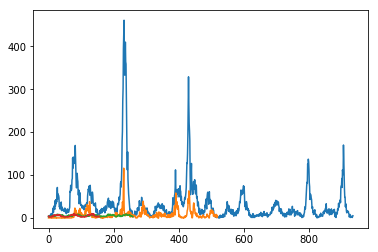

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sj_y)
plt.plot(iq_y)
plt.plot(predictions_sj)
plt.plot(predictions_iq)

In [15]:
optimized_GBM.grid_scores_

/home/tianshengs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -7.75651, std: 1.61262, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50},
 mean: -7.53004, std: 1.59813, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 75},
 mean: -7.33922, std: 1.57984, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100},
 mean: -7.75160, std: 1.61459, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50},
 mean: -7.53003, std: 1.59658, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 75},
 mean: -7.33515, std: 1.57630, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100},
 mean: -7.75495, std: 1.60962, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 50},
 mean: -7.53106, std: 1.59008, params: {'learning_rate': 0.003, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 75},
 mean: